## フェスマッチ（チャレンジ）からブキ偏差値を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.SPLATFEST_CHALLENGE
date_from = dt.date(2023, 5, 6)
date_to = date_from + dt.timedelta(days=3)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 8961
パワー不明バトル数: 1837


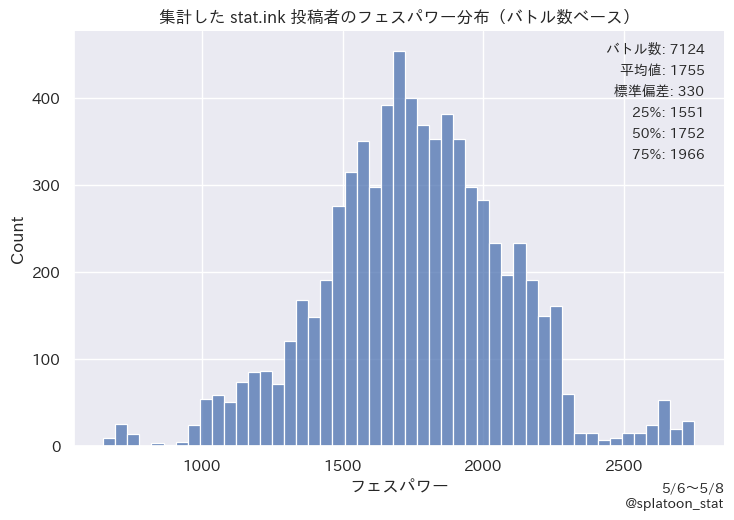

In [2]:
print(f"バトル数: {len(battles)}")
v.splatfest_challenge_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [4]:
usage = players["weapon"].value_counts(normalize=True).to_frame(name="usage")
power = players.groupby("weapon")["power"].mean().to_frame(name="power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = boxcox(weapon_stat["usage"])[0]
weapon_stat["usage-z"] = standardize(weapon_stat["usage-bc"])
weapon_stat["power-z"] = standardize(weapon_stat["power"])

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

,usage,power,usage-bc,usage-z,power-z,strength,strength-z,strength-t
sharp_neo,0.083568,1830.215417,-2.284854,2.358590,0.865302,2.355455,2.422687,74.226868
sshooter_collabo,0.056961,1689.580754,-2.604728,1.953200,-0.788382,0.973212,1.000990,60.009902
promodeler_rg,0.052625,1621.301068,-2.669778,1.870759,-1.591264,0.389093,0.400198,54.001984
sharp,0.037735,1853.581575,-2.939253,1.529241,1.140059,1.903253,1.957577,69.575770
screwslosher,0.034913,1972.448024,-3.001354,1.450537,2.537777,2.751151,2.829677,78.296772
...,...,...,...,...,...,...,...,...
bucketslosher_deco,0.001228,1736.874576,-5.388717,-1.575075,-0.232267,-1.348542,-1.387033,36.129667
rpen_5h,0.001164,1759.126786,-5.422551,-1.617954,0.029390,-1.211215,-1.245786,37.542138
h3reelgun,0.001164,1823.763158,-5.422551,-1.617954,0.789432,-0.717607,-0.738090,42.619103
l3reelgun,0.000797,1888.564103,-5.659094,-1.917737,1.551409,-0.450699,-0.463563,45.364365


### 可視化する

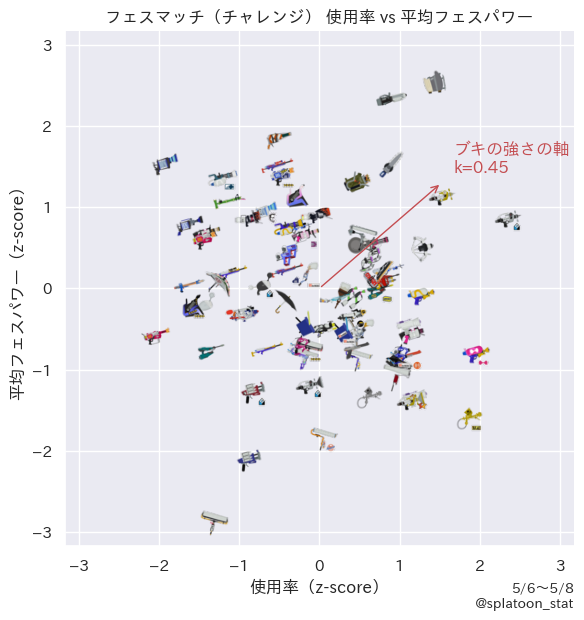

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均フェスパワー（z-score）", "Splatfest Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均フェスパワー", "Usage vs Splatfest Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    marker="",
    height=6,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for _, row in weapon_stat.iterrows():
    weapon = row.name
    xvalue = row["usage-z"]
    yvalue = row["power-z"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

# ブキの強さの軸のベクトルを表示する
ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

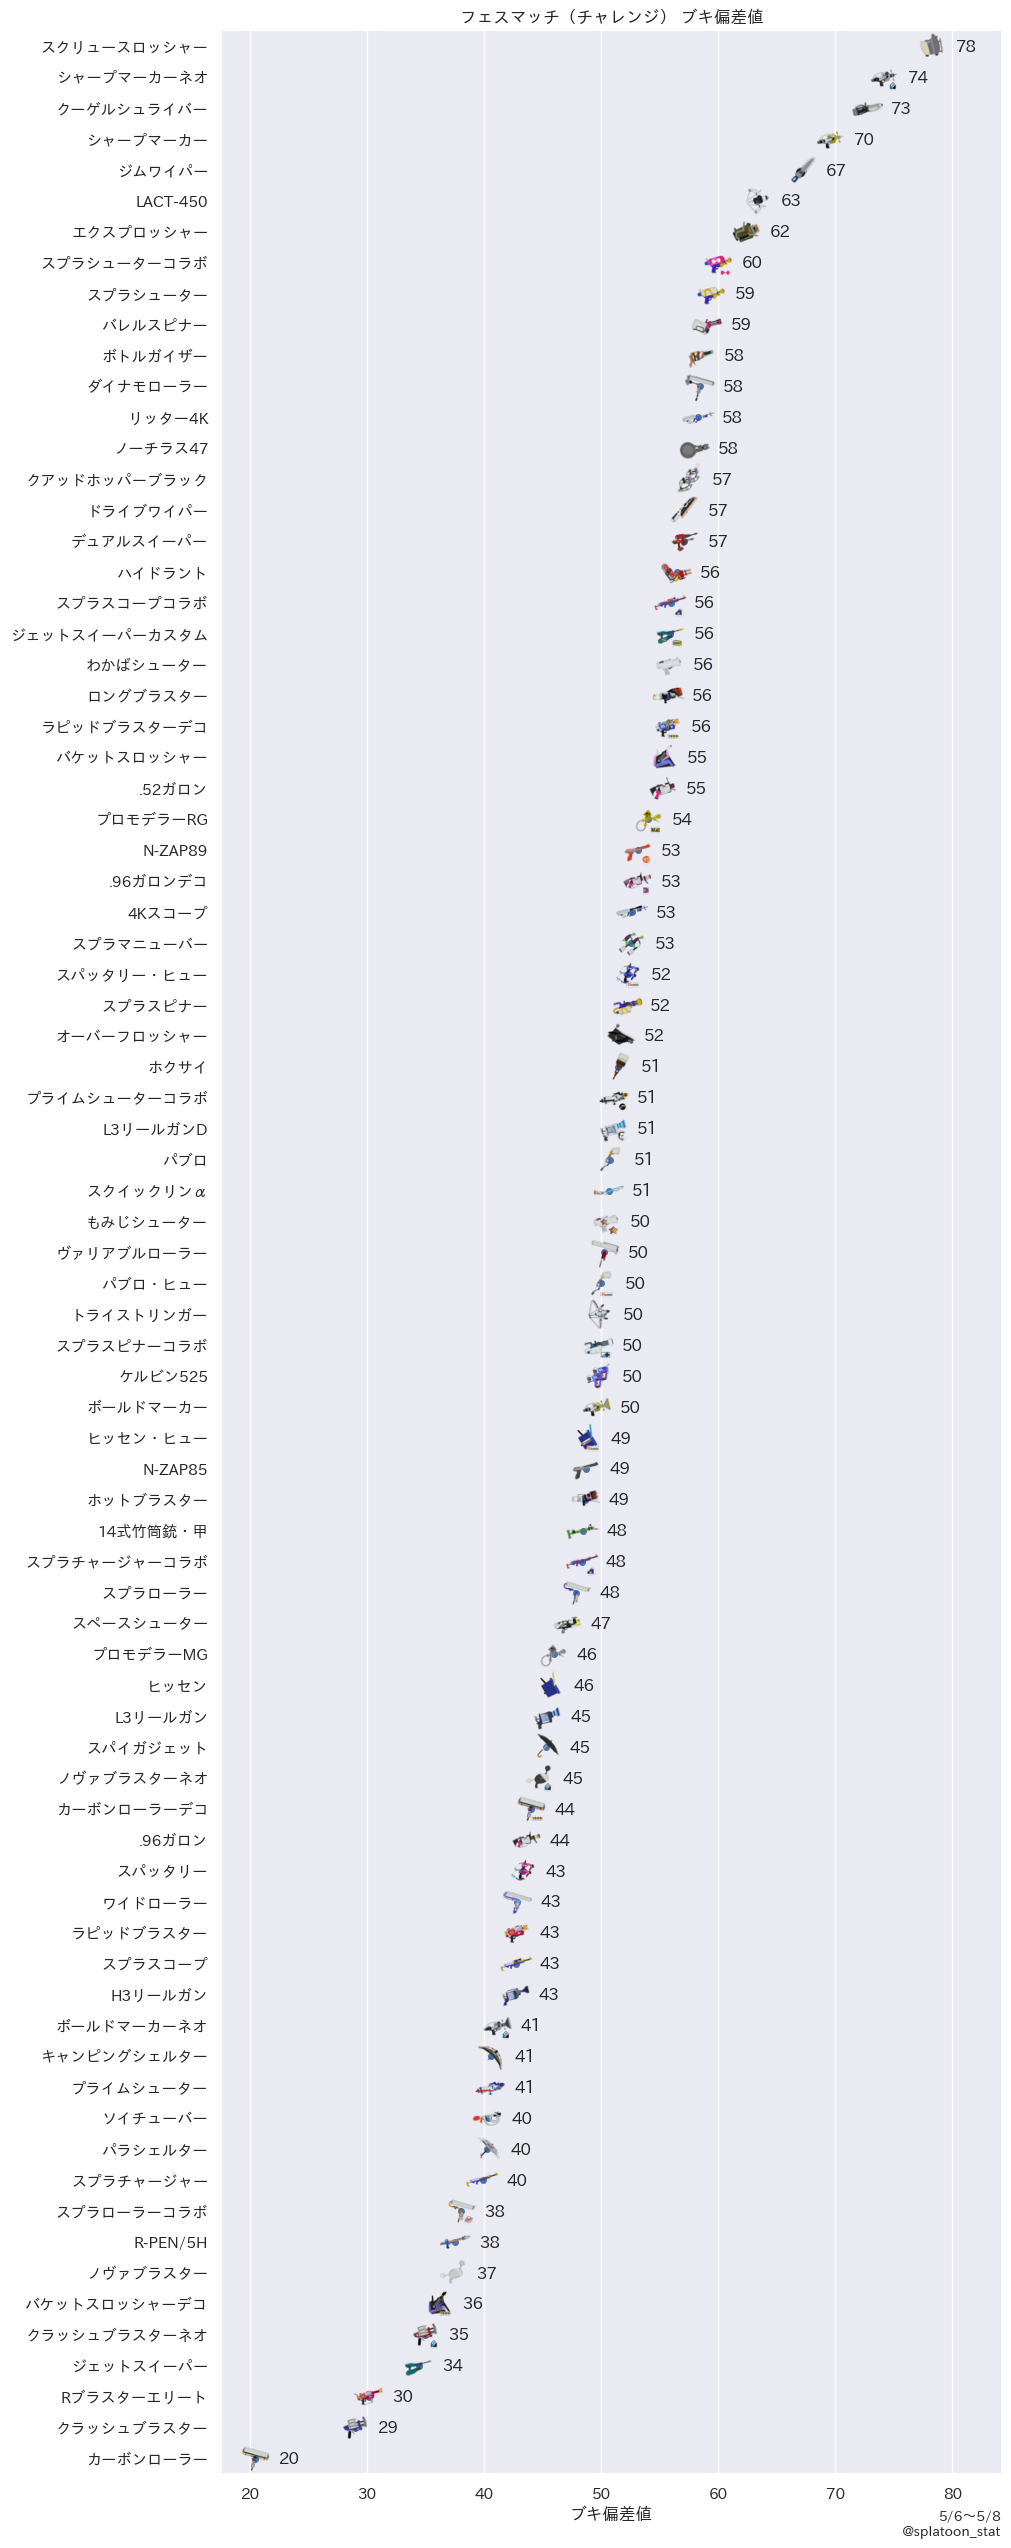

In [6]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

df = weapon_stat.sort_values("strength-t", ascending=False).reset_index().rename(columns={"index": "weapon"})
width = 10
height = len(df) * 0.32

g = sns.catplot(
    data=df,
    x="strength-t",
    y="weapon",
    height=height,
    aspect=width / height,
)
ax = g.ax

xmin, xmax = ax.get_xlim()
xkeys, ykeys = u.get_ax_ticklabels(ax)
yvalues = df["strength-t"].to_list()
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("strength"),
    ylabel="",
    yticks=ax.get_yticks(),
    yticklabels=yticklabels,
    xlim=(xmin, xmax + 3),
)

for i, (key, value) in enumerate(zip(ykeys, yvalues)):
    image_path = image.get_image_path(key)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (50, 0), xybox=(value, i), frameon=False, pad=0)
    ax.add_artist(ab)

    ax.annotate(round(value), (value + 2, i), va="center")

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()